# Bibliotecas

In [222]:
# ! pip install statsmodels -U
# !pip install pmdarima
# ! pip install ptitprince

In [223]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ndiffs, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import ptitprince as pt

# Dataset

In [224]:
# data_dir = '/content/drive/MyDrive/Datasets/NASA Acoustics and Vibration Database/2nd_test/2nd_test'
# df_rolamento = pd.DataFrame()

# for filename in os.listdir(data_dir):
#     dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
#     dataset_mean_abs = np.array(dataset.abs().mean())
#     dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
#     dataset_mean_abs.index = [filename]
#     df_rolamento = df_rolamento.append(dataset_mean_abs)

# df_rolamento.columns = ['bearing_1','bearing_2','bearing_3','bearing_4']

In [225]:
# df_rolamento.index = pd.to_datetime(df_rolamento.index,
#                                     format='%Y.%m.%d.%H.%M.%S').sort_values()

In [226]:
# df_rolamento.to_csv(path_or_buf='/content/drive/MyDrive/Datasets/NASA Acoustics and Vibration Database/df_rolamento_2nd_test.csv',
#                     sep=',',
#                     index=True,
#                     encoding='utf-8',
#                     index_label='index')

In [227]:
df_rolamento = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Datasets/NASA Acoustics and Vibration Database/df_rolamento_2nd_test.csv',
                           index_col=0)

In [228]:
df_rolamento.index = pd.to_datetime(df_rolamento.index,
                                      format='%Y-%m-%d %H:%M:%S')

In [229]:
df_rolamento

,bearing_1,bearing_2,bearing_3,bearing_4
index,,,,
2004-02-12 10:32:39,0.061630,0.075284,0.080999,0.044688
2004-02-12 10:42:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:52:39,0.061231,0.074172,0.082022,0.043840
2004-02-12 11:02:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 11:12:39,0.062599,0.075488,0.080626,0.044679
...,...,...,...,...
2004-02-19 05:42:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 05:52:39,0.351952,0.132498,0.127528,0.111187
2004-02-19 06:02:39,0.294231,0.152531,0.147832,0.109945


## Visualização

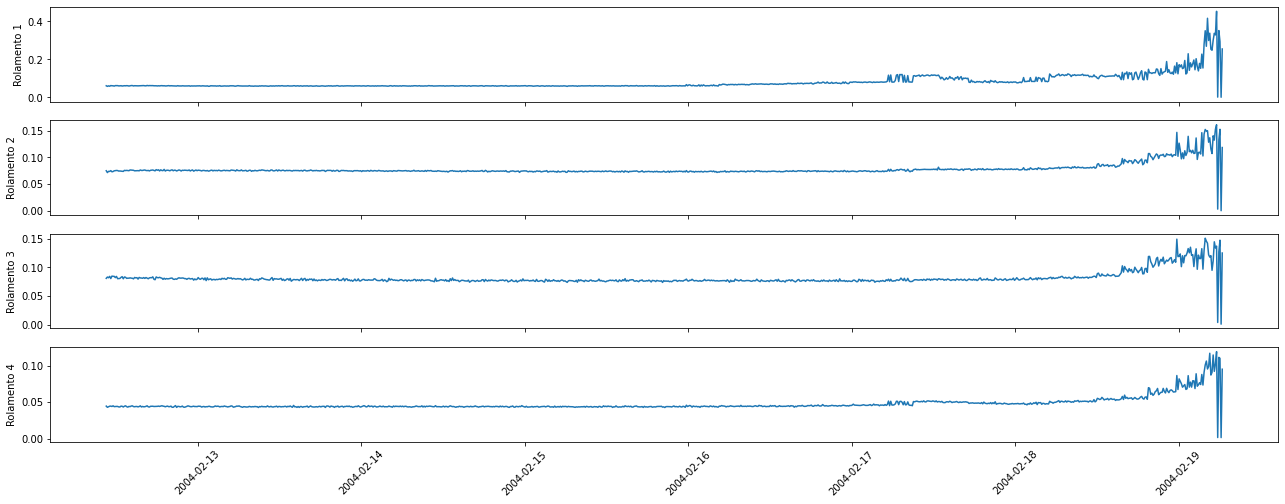

In [230]:
fig, ax = plt.subplots(nrows=4, sharex=True)
fig.set_size_inches(22, 8)

ax[0].plot('bearing_1', data=df_rolamento)
ax[0].set_ylabel('Rolamento 1')

ax[1].plot('bearing_2', data=df_rolamento)
ax[1].set_ylabel('Rolamento 2')

ax[2].plot('bearing_3', data=df_rolamento)
ax[2].set_ylabel('Rolamento 3')

ax[3].plot('bearing_4', data=df_rolamento)
ax[3].set_ylabel('Rolamento 4')
ax[3].tick_params(axis='x', rotation=45)

# Rolamento 1

In [231]:
df_rolamento = pd.DataFrame(df_rolamento['bearing_1']).copy()

df_rolamento

,bearing_1
index,
2004-02-12 10:32:39,0.061630
2004-02-12 10:42:39,0.058333
2004-02-12 10:52:39,0.061231
2004-02-12 11:02:39,0.058995
2004-02-12 11:12:39,0.062599
...,...
2004-02-19 05:42:39,0.001857
2004-02-19 05:52:39,0.351952
2004-02-19 06:02:39,0.294231


## Limite superior

### 3 sigma

In [232]:
media = df_rolamento.mean()[0]

desv_pad = df_rolamento.std()[0]

lim_sup_sigma = 3 * desv_pad + media

lim_sup_sigma

0.201419741180899

### Boxplot

In [233]:
primeiro_q = df_rolamento.describe().loc['25%'][0]

terceiro_q = df_rolamento.describe().loc['75%'][0]

lim_sup_boxplot = terceiro_q + 1.5 * (terceiro_q - primeiro_q)

lim_sup_boxplot

0.11690946213193988

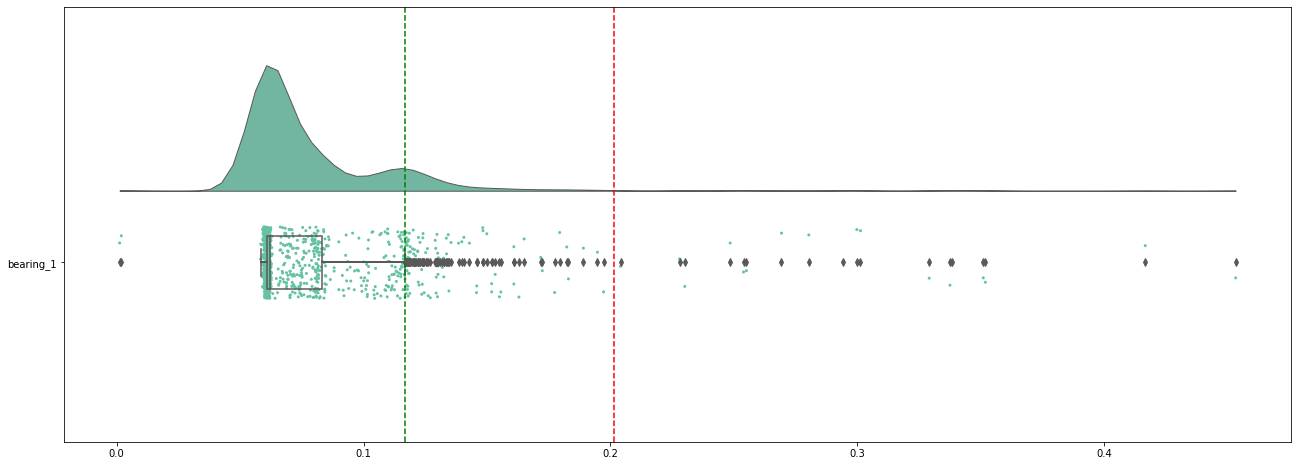

In [234]:
ax = pt.RainCloud(data=df_rolamento,
                  orient='h')

ax.axvline(lim_sup_sigma, color='r', linestyle='--')

ax.axvline(lim_sup_boxplot, color='green', linestyle='--')

ax.figure.set_size_inches(22,8)

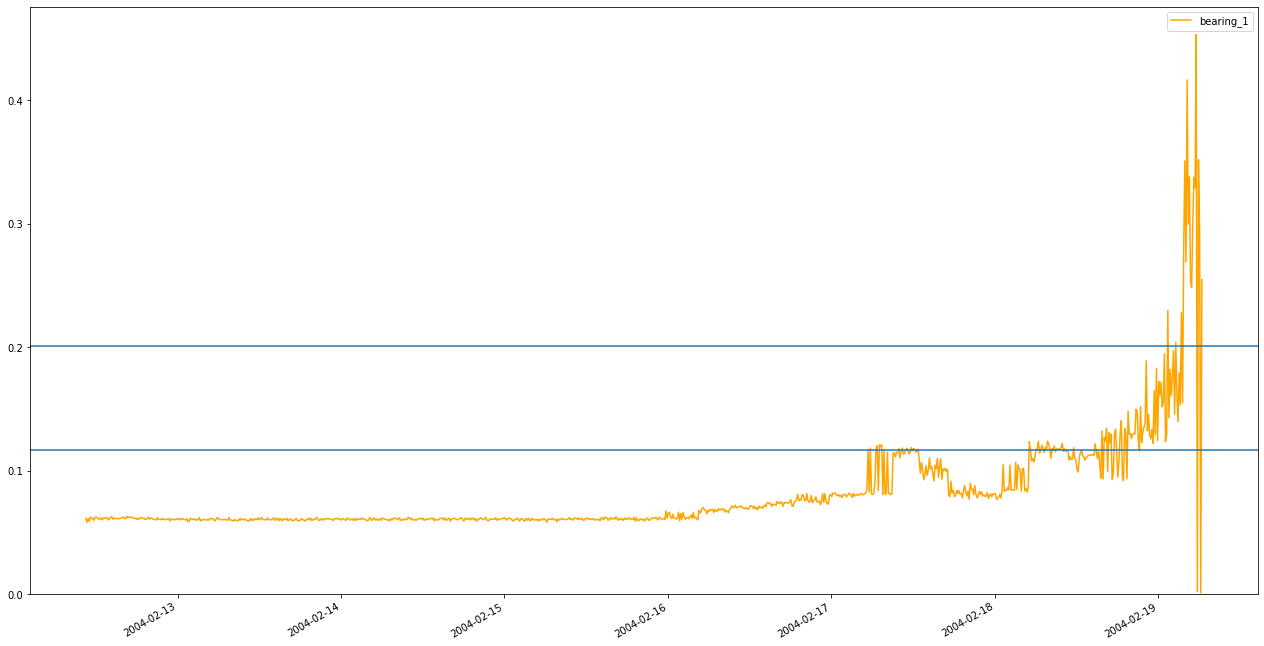

In [235]:
ax = df_rolamento.plot(color='orange')

ax.figure.set_size_inches(22,12)
ax.set_xlabel(None)

ax.set_ylim(0)

ax.axhline(lim_sup_sigma)
ax.axhline(lim_sup_boxplot)

In [236]:
index_pre = df_rolamento.loc[df_rolamento['bearing_1'] >= lim_sup_boxplot].index[0]

df_pre = df_rolamento.loc[df_rolamento.index <= index_pre]

df_pre = df_pre.resample(rule='H').mean()

# df_pre

# Teste de estacionariedade

## Teste de Dickey-Fuller

In [237]:
stat_t = adfuller(df_pre.dropna())[0]
p_valor = adfuller(df_pre.dropna())[1]

valor_critico_1 = adfuller(df_pre.dropna())[4].get('1%')
valor_critico_5 = adfuller(df_pre.dropna())[4].get('5%')
valor_critico_10 = adfuller(df_pre.dropna())[4].get('10%')

significancia= 0.05
# Se a significância for 1% ou 10% é necessário
# alterar a condicional no if

if valor_critico_5 <= stat_t and significancia <= p_valor:
    print('Hipótese nula aceita'
          '\nSérie temporal não estacionária')
else:
    print('Hipótese nula rejeitada'
          '\nSérie temporal estacionária')

Hipótese nula aceita
Série temporal não estacionária


## Autocorrelação

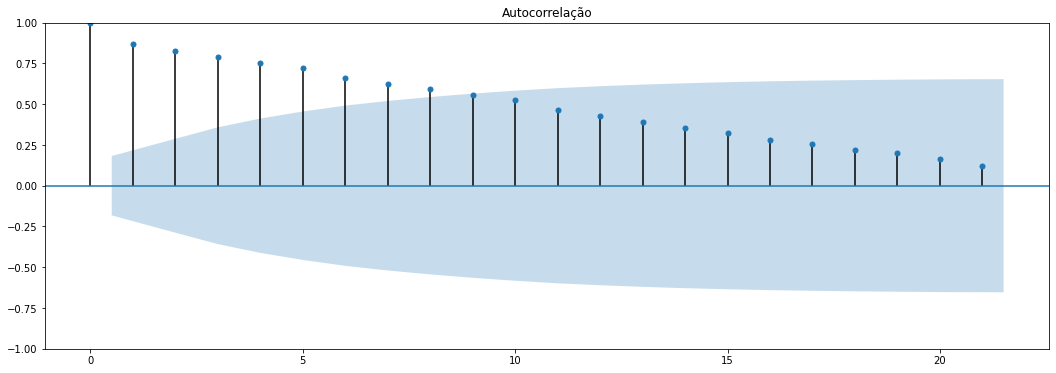

In [238]:
autocorr = plot_acf(df_pre, title='Autocorrelação')
autocorr.set_figheight(6)
autocorr.set_figwidth(18)
plt.show()

## Autocorrelação parcial

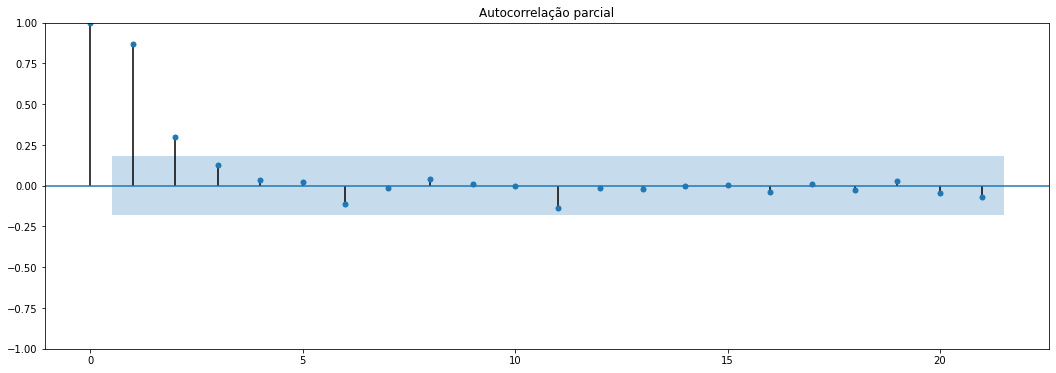

In [239]:
autocorr_parc = plot_pacf(df_pre,
                          title='Autocorrelação parcial',
                          method='ywm')
autocorr_parc.set_figheight(6)
autocorr_parc.set_figwidth(18)
plt.show()

## Diferenciação

In [240]:
ndiffs(df_pre, test='adf')

2

# ARIMA

## Parâmetros p, d, q

In [241]:
auto_arima = auto_arima(df_pre)

auto_arima

ARIMA(order=(0, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [242]:
modelo = ARIMA(endog=df_pre,
               order=(0, 2, 1),
               freq='H')

results = modelo.fit()

# print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Análise dos resíduos

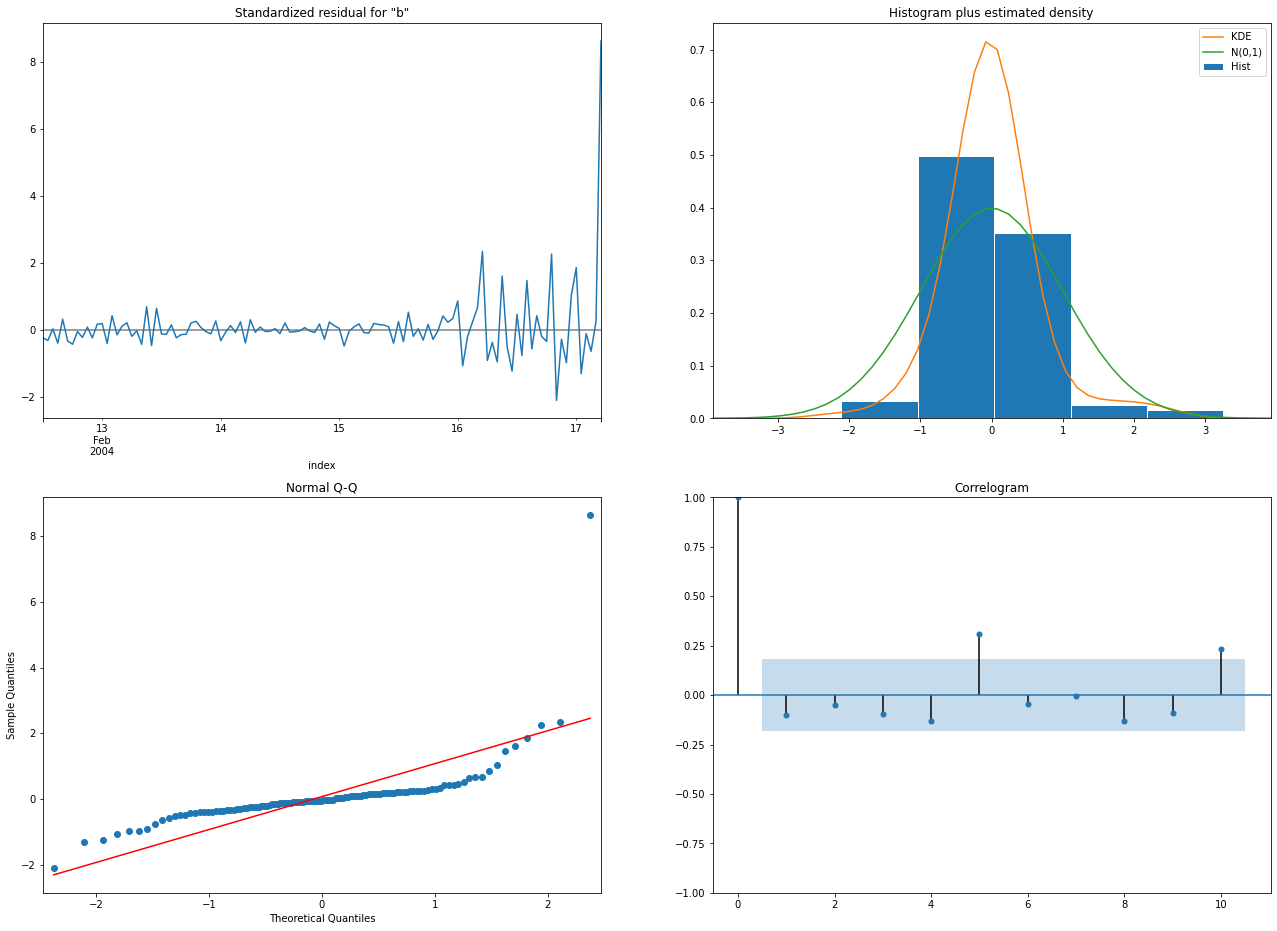

In [243]:
results.plot_diagnostics(figsize=(22,16));

# Previsão de valores



## Treino e teste

In [245]:
tam_treino = int(round(len(df_pre) * 0.7, 0))

In [246]:
train = df_pre.iloc[:tam_treino]

test = df_pre.iloc[tam_treino:]

## Interpolação

#### Modelo de previsão

In [247]:
pred = results.get_prediction(start=test.index[0],
                              dynamic=False)

### Intervalo de confiança

In [248]:
pred_ic = pred.conf_int()

### Análise gráfica

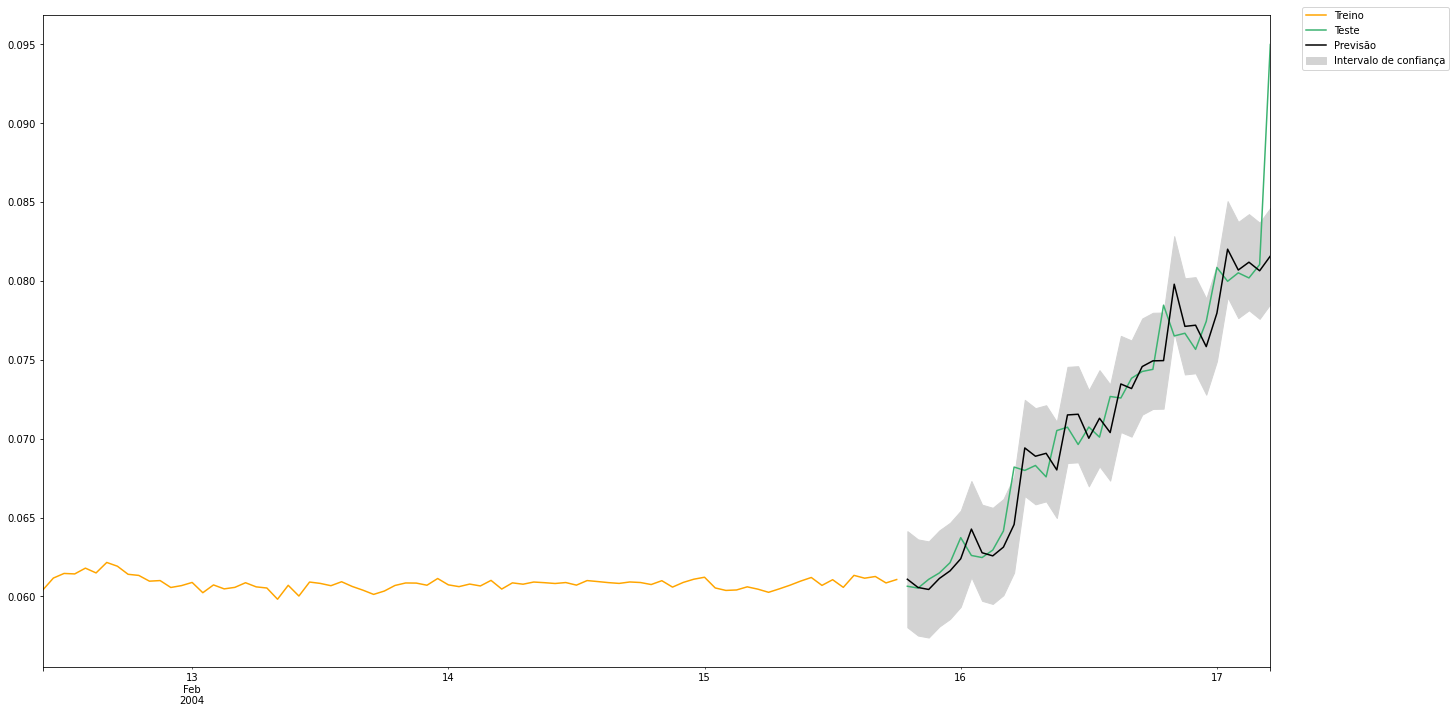

In [249]:
ax = train.plot(color='orange')

test.plot(ax=ax, color='mediumseagreen')

pred.predicted_mean.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.figure.set_size_inches(22,12)
ax.set_xlabel(None)
ax.legend(labels=['Treino',
                  'Teste',
                  'Previsão',
                  'Intervalo de confiança'],
                   bbox_to_anchor=(1.15, 1.02))

### Acurácia do modelo

#### Raiz do erro quadrático médio

In [250]:
from math import sqrt

rmse = sqrt(mean_squared_error(test,
                         pred.predicted_mean))

rmse

0.002755423211251531

#### Coeficiente de determinação (r²)

In [251]:
r_squared = r2_score(test,
                     pred.predicted_mean)

r_squared

0.8718657629000066

#### Erro médio absoluto

In [252]:
mae = mean_absolute_error(test,
                          pred.predicted_mean)

mae

0.0015968734274787342

## Extrapolação

In [270]:
pred_uc = results.get_forecast(steps=30) # Em cada passo deve ser considerado 1 h

### Intervalo de confiança

In [271]:
pred_ic = pred_uc.conf_int()

### Análise gráfica

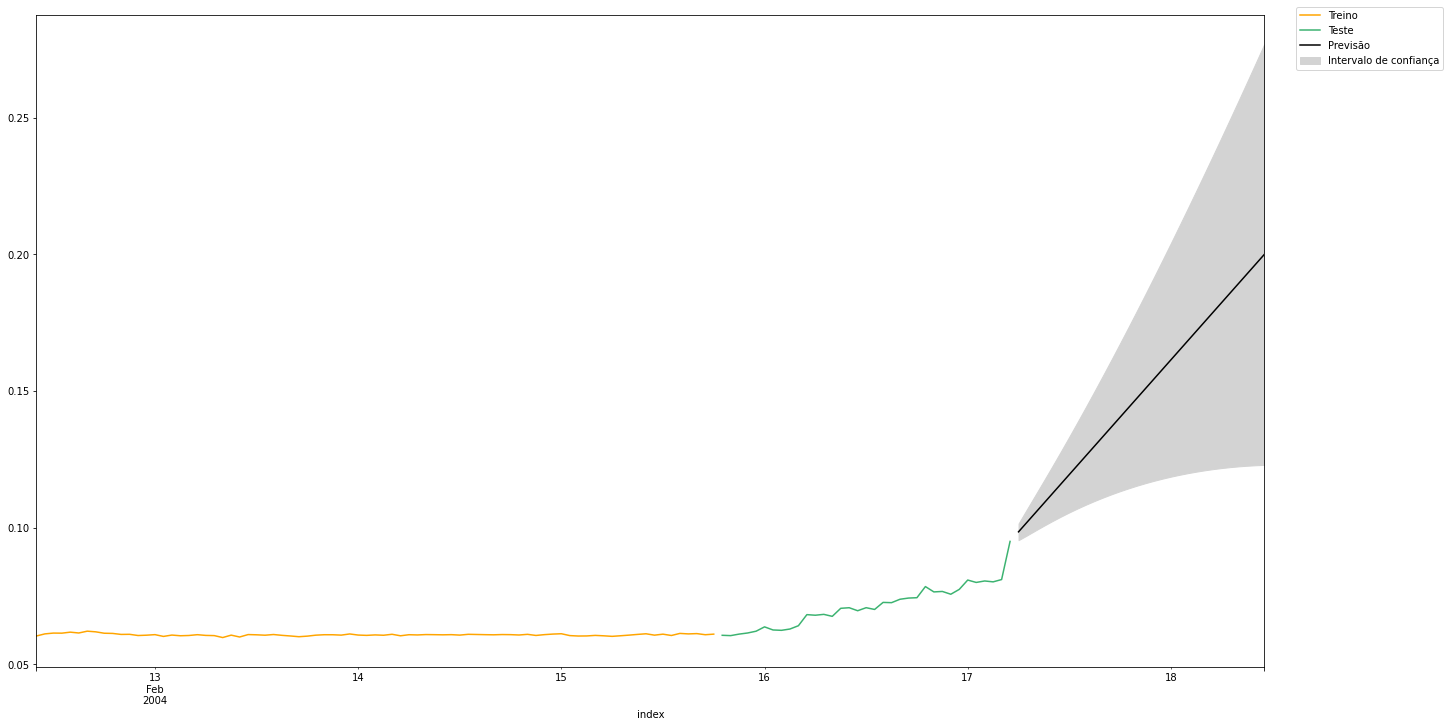

In [272]:
fig, ax = plt.subplots(figsize=(22, 12))

train.plot(ax=ax, color='orange')

test.plot(ax=ax, color='mediumseagreen')

pred_uc.predicted_mean.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.legend(labels=['Treino', 'Teste', 'Previsão', 'Intervalo de confiança'],
          bbox_to_anchor=(1.15, 1.02))

# Comparativo com dados reais

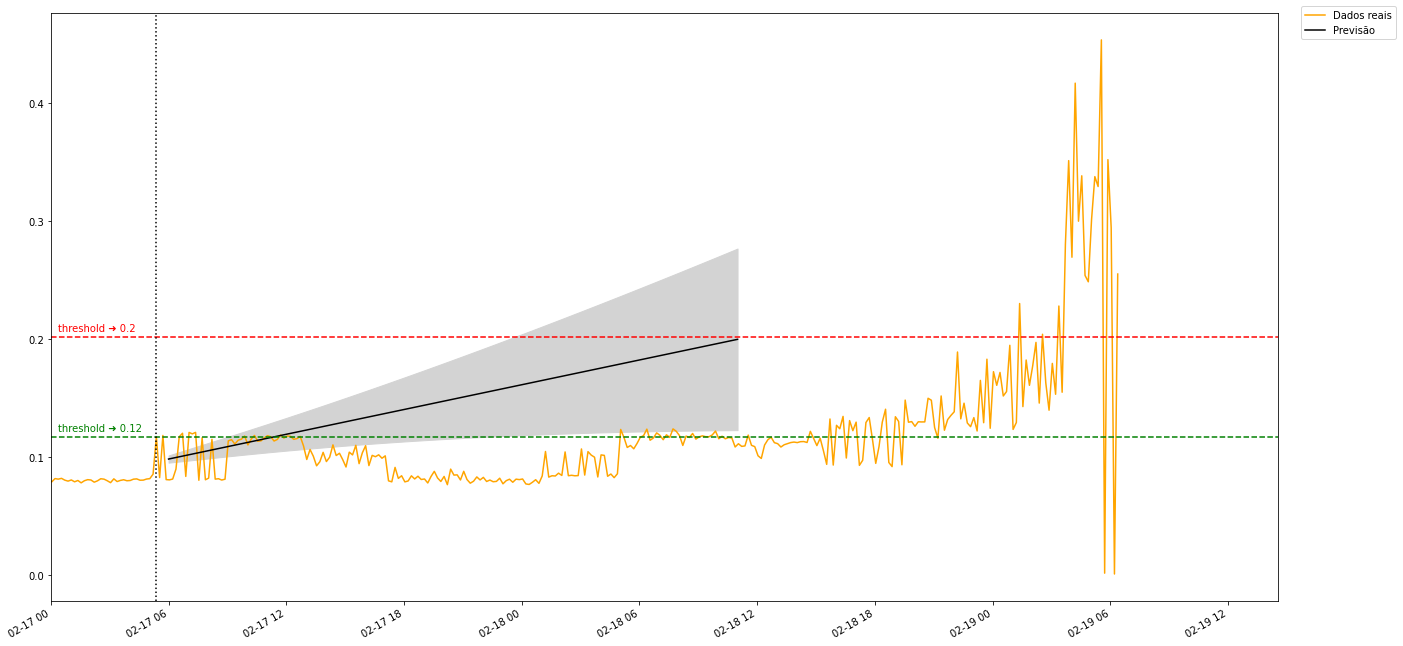

In [283]:
ax = df_rolamento.plot(color='orange')

ax.figure.set_size_inches(22,12)
ax.set_xlabel(None)

pred_uc.predicted_mean.plot(ax=ax, color='k')

ax.fill_between(pred_ic.index,
                pred_ic.iloc[:, 0],
                pred_ic.iloc[:, 1],
                color='lightgrey')

ax.legend(labels=['Dados reais', 'Previsão'],
          bbox_to_anchor=(1.1, 1.02))

ax.set_xlim(pd.to_datetime('2004-02-17'))

ax.axhline(lim_sup_sigma, color='r', linestyle='--')

ax.annotate(s='threshold ➜ ' + str(lim_sup_sigma.round(2)),
            xy=(pd.to_datetime('2004-02-17'), lim_sup_sigma),
            xytext=(pd.to_datetime('2004-02-17 00:22'), lim_sup_sigma + 0.005),
            color='r')

ax.axhline(lim_sup_boxplot, color='green', linestyle='--')

ax.annotate(s='threshold ➜ ' + str(lim_sup_boxplot.round(2)),
            xy=(pd.to_datetime('2004-02-17'), lim_sup_boxplot),
            xytext=(pd.to_datetime('2004-02-17 00:22'), lim_sup_boxplot + 0.005),
            color='green')

ax.axvline(index_pre, color='k', linestyle=':')